In [3]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

# CDT

In [4]:
# new metric
import numpy as np
from scipy.ndimage import distance_transform_cdt

# adjust commonNNClustering to used framework
class NearestOpponentEstimator:
    
    def __init__(self, metric="chessboard"):
        self.metric = metric
    
    def fit(self, X_): # X_ is 2d array
        h, w = X_.shape
        a = 0; b = 1
        extended_arr = np.concatenate([X_] * 3, axis=0)
        extended_arr = np.concatenate([extended_arr] * 3, axis=1)
        dist_transform_a = \
            distance_transform_cdt(~(extended_arr == a), metric=self.metric)
        dist_transform_b = \
            distance_transform_cdt(~(extended_arr == b), metric=self.metric)
        dist_transform_a = dist_transform_a[h:2*h, w:2*w]
        dist_transform_b = dist_transform_b[h:2*h, w:2*w]
        return np.where(X_ == b, dist_transform_a, dist_transform_b)

In [5]:
# check that file has valid affinity states
file = "../data/uniform/data_A_seed100.csv"
attitudes = np.genfromtxt(file, delimiter=' ')

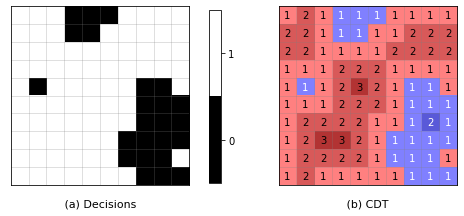

In [6]:
# explanatory CDT graphics
grid_attitude = attitudes[230].reshape(100, 100)[:10, :10]
grid_decision = np.int32(grid_attitude >= 0.5)

noe = NearestOpponentEstimator()

transformed = noe.fit(grid_decision)

# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

colors = ((0, 0, 0), (1, 1, 1))
cmap_bw = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

im0 = ax0.imshow(grid_decision, cmap=cmap_bw)
ax1.imshow(transformed, cmap="gray_r", alpha=0.6)
im1 = ax1.imshow(grid_decision, cmap="bwr", alpha=0.5)

for (j,i), label in np.ndenumerate(transformed):
    c = colors[np.int32(grid_decision[j, i] <= 0.5)]
    ax1.text(i, j, label, ha='center', va='center', color=c)

for ax in (ax0, ax1):
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(1, grid_decision.shape[0]):
    ax0.axhline(i - 0.5, color="gray", lw=0.5, alpha=0.5)
    ax1.axhline(i - 0.5, color="gray", lw=0.5, alpha=0.5)
for i in range(1, grid_decision.shape[1]):
    ax0.axvline(i - 0.5, color="gray", lw=0.5, alpha=0.5)
    ax1.axvline(i - 0.5, color="gray", lw=0.5, alpha=0.5)

    
cbar_ax = fig.add_axes([0.47, 0.26, 0.02, 0.48])
cbar = fig.colorbar(im0, cax=cbar_ax)
#cbar.ax.set_ylabel("Decision", rotation=-90, va="bottom")
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels([0, 1])

plt.subplots_adjust(wspace=0.5)

ax0.set_xlabel(" (a) Decisions ", fontsize=11, labelpad=14)
ax1.set_xlabel(" (b) CDT ", fontsize=11, labelpad=14)
plt.show()


In [7]:
def chessboard_distance(point1, point2):
    return max([abs(point1[0] - point2[0]), abs(point1[1] - point2[1])])

def nearest_opponent_fit_slow(X_):
    h, w = X_.shape
    extended_arr = np.concatenate([X_] * 3, axis=0)
    extended_arr = np.concatenate([extended_arr] * 3, axis=1)
    transformed = np.ones(extended_arr.shape) * 100
    for (i, j), v in np.ndenumerate(extended_arr):
        for (k, l), v2 in np.ndenumerate(extended_arr):
            if v != v2:
                transformed[i, j] = min(transformed[i, j], chessboard_distance((i, j), (k, l)))
    return transformed[h:2*h, w:2*w]

def CDT_custom_impl(decisions):
    transformed = np.ones(decisions.shape) * 100
    transformed = np.multiply(transformed, decisions == 1)
    n_rows, n_cols = decisions.shape
    for i in range(n_rows):
        for j in range(n_cols):
            if decisions[i, j] == 1:
                if i > 0 and i < n_rows-1 and j > 0:
                    transformed[i, j] = \
                        min(transformed[i-1, j-1], transformed[i, j-1], transformed[i-1, j], transformed[i+1, j-1]) + 1
                elif i > 0 and j > 0:
                    transformed[i, j] = \
                        min(transformed[i-1, j-1], transformed[i, j-1], transformed[i-1, j]) + 1
                elif i == 0 and j > 0:
                    transformed[i, j] = min(transformed[i, j-1], transformed[i+1, j-1]) + 1
                elif i > 0 and j == 0:
                    transformed[i, j] = transformed[i-1, j] + 1
    for i in range(n_rows-1, -1, -1):
        for j in range(n_cols-1, -1, -1):
            if decisions[i, j] == 1:
                val = 100
                if i < n_rows-1 and j < n_cols-1:
                    val = \
                        min(transformed[i+1, j+1], transformed[i, j+1], transformed[i+1, j], transformed[i-1, j+1]) + 1
                elif i == n_rows-1 and j < n_cols-1:
                    val = min(transformed[i, j+1], transformed[i-1, j+1]) + 1
                elif i < n_rows-1 and j == n_cols-1:
                    val = transformed[i+1, j] + 1
                transformed[i, j] = min(transformed[i, j], val)
    return transformed

def CDT_custom_impl_fit(X_):
    h, w = X_.shape
    a, b = 0, 1
    extended_arr = np.concatenate([X_] * 3, axis=0)
    extended_arr = np.concatenate([extended_arr] * 3, axis=1)
    extended_arr = np.concatenate([X_] * 3, axis=0)
    extended_arr = np.concatenate([extended_arr] * 3, axis=1)
    dist_transform_a = CDT_custom_impl(~(extended_arr == a))
    dist_transform_b = CDT_custom_impl(~(extended_arr == b))
    dist_transform_a = dist_transform_a[h:2*h, w:2*w]
    dist_transform_b = dist_transform_b[h:2*h, w:2*w]
    return np.where(X_ == b, dist_transform_a, dist_transform_b)

chessboard_distance((0, 0), (1, 2))

t = nearest_opponent_fit_slow(grid_decision[:10, :10])

t = nearest_opponent_fit_slow(grid_decision[:2, :2])
#sns.heatmap(t, annot=True)

In [74]:
# time analysis benchmarks
import timeit, functools

# explanatory CDT graphics
grid_attitude = attitudes[230].reshape(100, 100)
grid_decision = np.int32(grid_attitude >= 0.5)

noe = NearestOpponentEstimator()

def NumpyCDT(n):
    t = noe.fit(grid_decision[:n, :n])


def StandardDT(n):
    t = nearest_opponent_fit_slow(grid_decision[:n, :n])


def TwoPassCDT(n):
    t = CDT_custom_impl_fit(grid_decision[:n, :n])
    
    
num_runs = 10
num_repetions = 30

# # run benchmarks
# for N_ in (2, 4, 6, 8, 10):
    
#     ex_time = timeit.Timer(functools.partial(test_func, N_)).repeat(repeat=num_repetions, number=num_runs)
#     print(f'Numpy impl. for N={N_} took {np.mean(ex_time)* 1e3:.3f} +- {np.std(ex_time)* 1e3:.3f} ms')

#     ex_time = timeit.Timer(functools.partial(test_func_slow, N_)).repeat(repeat=num_repetions, number=num_runs)
#     print(f'Slow impl. for N={N_} took {np.mean(ex_time)* 1e3:.4f} +- {np.std(ex_time)* 1e3:.4f} ms')

#     ex_time = timeit.Timer(functools.partial(test_func_custom, N_)).repeat(repeat=num_repetions, number=num_runs)
#     print(f'Custom impl. for N={N_} took {np.mean(ex_time)* 1e3:.4f} +- {np.std(ex_time)* 1e3:.4f} ms')
    
N_values = (4, 8, 16)

table = []
for N_ in N_values:
    for test_func in [NumpyCDT, StandardDT, TwoPassCDT]:
        name = test_func.__name__
        N = N_ * N_
        N_ext = N * 3 * 3
        result = timeit.Timer(functools.partial(test_func, N_)).repeat(repeat=num_repetions, number=num_runs)
        mean = np.mean(result) / num_repetions
        error = np.std(result) / np.sqrt(num_repetions) / num_repetions
        stddev = np.std(result) / num_repetions
        table.append((name, N_, N_ext, mean, error, stddev))

In [21]:
%%timeit -n 2 -r 1
NumpyCDT(16)

518 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


In [75]:
import numpy as np

def round_to_error(value, error, stddev):
    error_digits = int(np.floor(np.log10(error)))
    if error * 10**(-error_digits) <= 4.00:
        error_digits -= 1
    return round(value, -error_digits), round(error, -error_digits), round(stddev, -error_digits)

def format_si(value, scale):
    if scale > 0:
        value *= 1e3**scale
        units = {
            0: "",
            1: "\milli",
            2: "\micro",
            3: "\nano",
        }
        unit = units[scale]
    else: 
        unit = ""
    return f"\\SI{{{value}}}{{{unit}\s}}"
    

def find_scale(value):
    scale = 0
    while abs(value)*1e3**scale <= 1.:
        scale += 1
    while abs(value)*1e3**scale > 1e3:
        scale -= 1
    return scale

def process_row(row):
    method, N_x, N_ext, mean, error, stddev = row
    mean, error, stddev = round_to_error(mean, error, stddev)
    scale = find_scale(mean)
    scale_err = find_scale(error*1e2)
    scale_stddev = find_scale(stddev*1e2)
    if scale_err < scale:
        scale = scale_err
    return (method, N_x, N_ext, format_si(mean, scale), format_si(error, scale_err), format_si(stddev, scale_stddev))

processed_data = [process_row(row) for row in table]

def create_table(data):
    s = "\\begin{tabular}{@{} l r r r r r @{}}"
    s += "\n" + "\\toprule"
    s += "\n" + "Method & N_x & N (extended) & Mean (per loop) & Error & StdDev \\\\"
    s += "\n" + "\\midrule"
    for row in data:
        s += "\n" + " & ".join([str(x) for x in row]) + "\\\\"
    s += "\n" + "\\bottomrule"
    s += "\n" + "\\end{tabular}"
    return s
    
latex_table = create_table(processed_data)
print(latex_table)


\begin{tabular}{@{} l r r r r r @{}}
\toprule
Method & N_x & N (extended) & Mean (per loop) & Error & StdDev \\
\midrule
NumpyCDT & 4 & 144 & \SI{25.8}{\micro\s} & \SI{1.7999999999999998}{\micro\s} & \SI{10.0}{\micro\s}\\
StandardDT & 4 & 144 & \SI{3.212}{\milli\s} & \SI{0.026}{\milli\s} & \SI{0.14200000000000002}{\milli\s}\\
TwoPassCDT & 4 & 144 & \SI{372.3}{\micro\s} & \SI{2.4}{\micro\s} & \SI{0.0133}{\milli\s}\\
NumpyCDT & 8 & 576 & \SI{27.4}{\micro\s} & \SI{0.5}{\micro\s} & \SI{2.5}{\micro\s}\\
StandardDT & 8 & 576 & \SI{72.2}{\milli\s} & \SI{2.5}{\milli\s} & \SI{0.0137}{\s}\\
TwoPassCDT & 8 & 576 & \SI{1.824}{\milli\s} & \SI{9.0}{\micro\s} & \SI{0.051}{\milli\s}\\
NumpyCDT & 16 & 2304 & \SI{56.879999999999995}{\micro\s} & \SI{0.19999999999999998}{\micro\s} & \SI{1.12}{\micro\s}\\
StandardDT & 16 & 2304 & \SI{1.544}{\s} & \SI{0.019}{\s} & \SI{0.105}{\s}\\
TwoPassCDT & 16 & 2304 & \SI{7.015000000000001}{\milli\s} & \SI{0.037}{\milli\s} & \SI{0.202}{\milli\s}\\
\bottomrule
\end{tabul

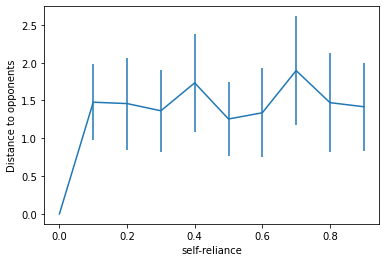

In [11]:
def bin_data(arr1, arr2, bins):
    hist, bin_edges = np.histogram(arr1.flatten(), bins=bins)
    bin_index = np.digitize(arr1, bin_edges)
    return bin_index

bins = np.linspace(0, 1, 11)
data = [[] for i in range(1, len(bins))]

seeds = [*range(100, 102)]
for seed in seeds:
    file = "../data/uniform/data_A_seed100.csv"
    attitudes = np.genfromtxt(file, delimiter=' ')
    decisions = np.int32(attitudes[230].reshape(100, 100) >= 0.5)
    distances = NearestOpponentEstimator().fit(decisions)
    bin_index = bin_data(attitudes[230].reshape(100, 100), distances, bins)
    for i in range(1, len(bins) - 1):
        data[i].extend(distances.flatten()[bin_index.flatten() == i])
        
means = [np.array(row).mean() if row else 0 for row in data]
stddev = [np.array(row).std() if row else 0 for row in data]

import matplotlib.pyplot as plt

plt.figure()
plt.errorbar(bins[:-1], means, yerr=stddev)

plt.xlabel("self-reliance")
plt.ylabel("Distance to opponents")
plt.show()

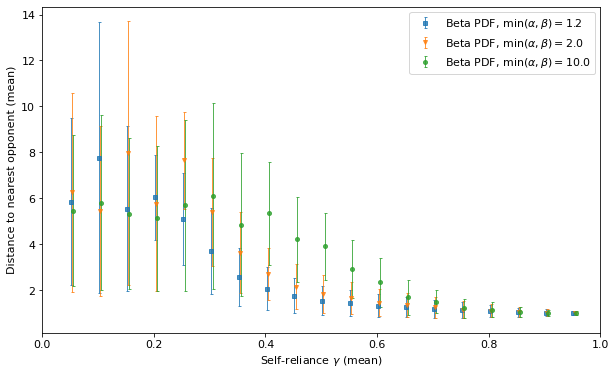

In [17]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 11, "figure.dpi": 147})


# plot beta
min_alpha_beta = (1.2, 2.0, 10.0)
colors = ("tab:blue", "tab:orange", "tab:green",)
markers = ("s", "v", "o", "*", )
i = 0
for value, color, marker in zip(min_alpha_beta, colors, markers):
    i += 1
    filtered_ = list(
        filter(lambda x_: min(x_.distribution.alpha, x_.distribution.beta) == value, nearest_opponents)
    )

    x = [n_.distribution.mean+i*0.002 for n_ in filtered_]
    y = [np.mean([np.mean(arr) for arr in n_.distances[1:] if arr]) for n_ in filtered_]
    yerr = [np.mean([np.std(arr) for arr in n_.distances[1:] if arr]) for n_ in filtered_]
    
    variance_at05 = 1./(2 * (2 * value + 1))
    label = f"Beta PDF, " + fr"$\min(\alpha, \beta)={value:.1f}$"
    
    plt.errorbar(x, y, yerr=yerr, c=color, alpha=0.8, label=label, 
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5)

# plot const

plt.xlim([0, 1])
plt.legend(loc="upper right")
plt.xlabel(r"Self-reliance $\gamma}$ (mean)")
plt.ylabel("Distance to nearest opponent (mean)")

plt.show()

In [39]:
beta_files

[('agent_data_beta_a-1.20_b-1.20_m-0.50.csv',
  BetaPdf(mean=0.5, alpha=1.2, beta=1.2)),
 ('agent_data_beta_a-1.20_b-1.47_m-0.45.csv',
  BetaPdf(mean=0.45, alpha=1.2, beta=1.47)),
 ('agent_data_beta_a-1.20_b-1.80_m-0.40.csv',
  BetaPdf(mean=0.4, alpha=1.2, beta=1.8)),
 ('agent_data_beta_a-1.20_b-10.80_m-0.10.csv',
  BetaPdf(mean=0.1, alpha=1.2, beta=10.8)),
 ('agent_data_beta_a-1.20_b-2.23_m-0.35.csv',
  BetaPdf(mean=0.35, alpha=1.2, beta=2.23)),
 ('agent_data_beta_a-1.20_b-2.80_m-0.30.csv',
  BetaPdf(mean=0.3, alpha=1.2, beta=2.8)),
 ('agent_data_beta_a-1.20_b-22.80_m-0.05.csv',
  BetaPdf(mean=0.05, alpha=1.2, beta=22.8)),
 ('agent_data_beta_a-1.20_b-3.60_m-0.25.csv',
  BetaPdf(mean=0.25, alpha=1.2, beta=3.6)),
 ('agent_data_beta_a-1.20_b-4.80_m-0.20.csv',
  BetaPdf(mean=0.2, alpha=1.2, beta=4.8)),
 ('agent_data_beta_a-1.20_b-6.80_m-0.15.csv',
  BetaPdf(mean=0.15, alpha=1.2, beta=6.8)),
 ('agent_data_beta_a-1.47_b-1.20_m-0.55.csv',
  BetaPdf(mean=0.55, alpha=1.47, beta=1.2)),
 ('agent

In [52]:
load_columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]

def add_nearest_opponents(df, file, beta_mode, beta_concentration):
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    final_step = 100 
    data_ = LoadSimulation(file, columns=columns)
    n_select = 20
    seeds_ = np.random.choice(data_.get("seed").unique(), size=n_select)

    # init cluster props
    estimator = NearestOpponentEstimator()
    
    for j, seed in enumerate(seeds_):
        sample = data_.query("seed == @seed")
        grid_data = Grid(Choice(sample, final_step))
        decisions = np.int32(grid_data >= 0.5)
        distances = estimator.fit(decisions)
        
        new_rows = pd.DataFrame({
            "attitude": grid_data.flatten(),
            "fixed attitude": Belief(sample, final_step),
            "self-reliance": Avantgarde(sample, final_step),
            "distance": distances.flatten(), 
            "mode self-reliance": beta_mode, 
            "concentration self-reliance": beta_concentration # 1. / ( 4 + 8 * min(distribution.alpha, distribution.beta) )
        })
        df = pd.concat([df, new_rows], ignore_index=True)
    return df

nearest_opponents_df = pd.DataFrame(columns=[
    "attitude",
    "fixed attitude",
    "self-reliance", 
    "distance", 
    "mode self-reliance", 
    "concentration self-reliance"
])

location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

@dataclass
class BetaPdf:
    mode: float
    concentration: float

files = []
beta_params = []
concentration = "5.0"
for fname in os.listdir(location):
    if f"beta-avantgarde" in fname and "_mode" in fname:
        if fname.split("concentration-")[1].split(".csv")[0] == concentration and \
            np.round(float(fname.split("mode-")[1].split("_concentration")[0]), 1) in np.round(np.arange(0.1, 0.91, 0.2), 2):
            mode = np.round(float(fname.split("mode-")[1].split("_concentration")[0]), 1)
            beta_params.append((mode, concentration))
            files.append(os.path.join(location, fname))
            
for file, (beta_mode, beta_concentration) in zip(files, beta_params):
    print(f"Load data for file {file}")
    nearest_opponents_df = add_nearest_opponents(nearest_opponents_df, file, beta_mode, beta_concentration)

nearest_opponents_df

Load data for file ..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-5.0.csv
Load data for file ..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-5.0.csv
Load data for file ..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-5.0.csv
Load data for file ..\data\paramstest\agent_data_beta-avantgarde_mode-0.70_concentration-5.0.csv
Load data for file ..\data\paramstest\agent_data_beta-avantgarde_mode-0.90_concentration-5.0.csv


,attitude,fixed attitude,self-reliance,distance,mode self-reliance,concentration self-reliance
0,0.511948,0.117646,0.637561,4,0.1,5.0
1,0.510294,0.181896,0.278328,3,0.1,5.0
2,0.508668,0.871003,0.092855,3,0.1,5.0
3,0.507083,0.009836,0.074524,2,0.1,5.0
4,0.505532,0.185447,0.201613,2,0.1,5.0
...,...,...,...,...,...,...
999995,0.449226,0.231977,0.830822,1,0.9,5.0
999996,0.49239,0.247023,0.686364,1,0.9,5.0
999997,0.580148,0.530775,0.878403,1,0.9,5.0
999998,0.648529,0.821052,0.846347,2,0.9,5.0


In [32]:
filtered_nearest_opponents_df.rename(columns={"self-reliance": "Self-reliance"}, inplace=True)

C:\Users\hoedtke\AppData\Local\Temp/ipykernel_14848/546895159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nearest_opponents_df.rename(columns={


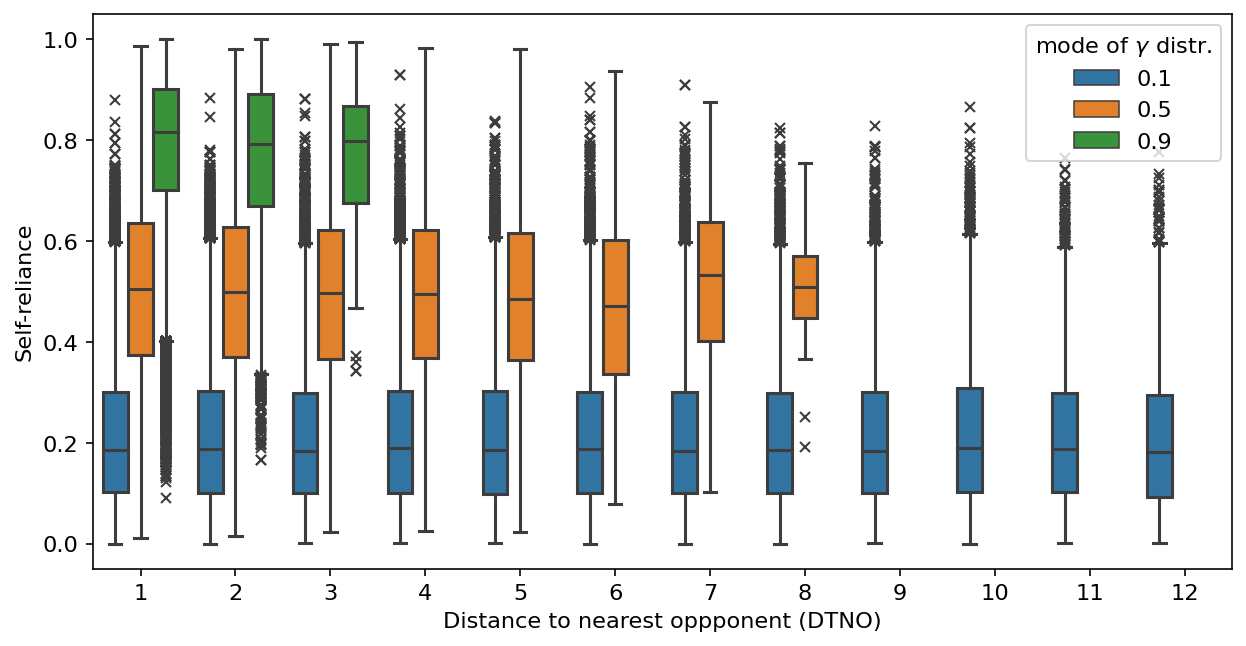

In [95]:
plt.figure(figsize=(10, 5))

beta_means = (0.1, 0.5, 0.9)

filtered_nearest_opponents_df = nearest_opponents_df[nearest_opponents_df["mode self-reliance"].isin([0.1, 0.5, 0.9])]
filtered_nearest_opponents_df.rename(columns={
    "self-reliance": "Self-reliance", 
    "distance": "Distance to nearest oppponent (DTNO)",
    "mode self-reliance": r"mode of $\gamma$ distr."
    }, inplace=True)
filtered_nearest_opponents_df = filtered_nearest_opponents_df[
    filtered_nearest_opponents_df["Distance to nearest oppponent (DTNO)"] <= 12]
sns.boxplot(data=filtered_nearest_opponents_df.sample(n=500_000), x="Distance to nearest oppponent (DTNO)", 
              y="Self-reliance", hue=r"mode of $\gamma$ distr.", 
              showfliers=True, flierprops={"marker": "x"})
plt.show()

C:\Users\hoedtke\AppData\Local\Temp/ipykernel_14848/1361739726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nearest_opponents_df.rename(columns={


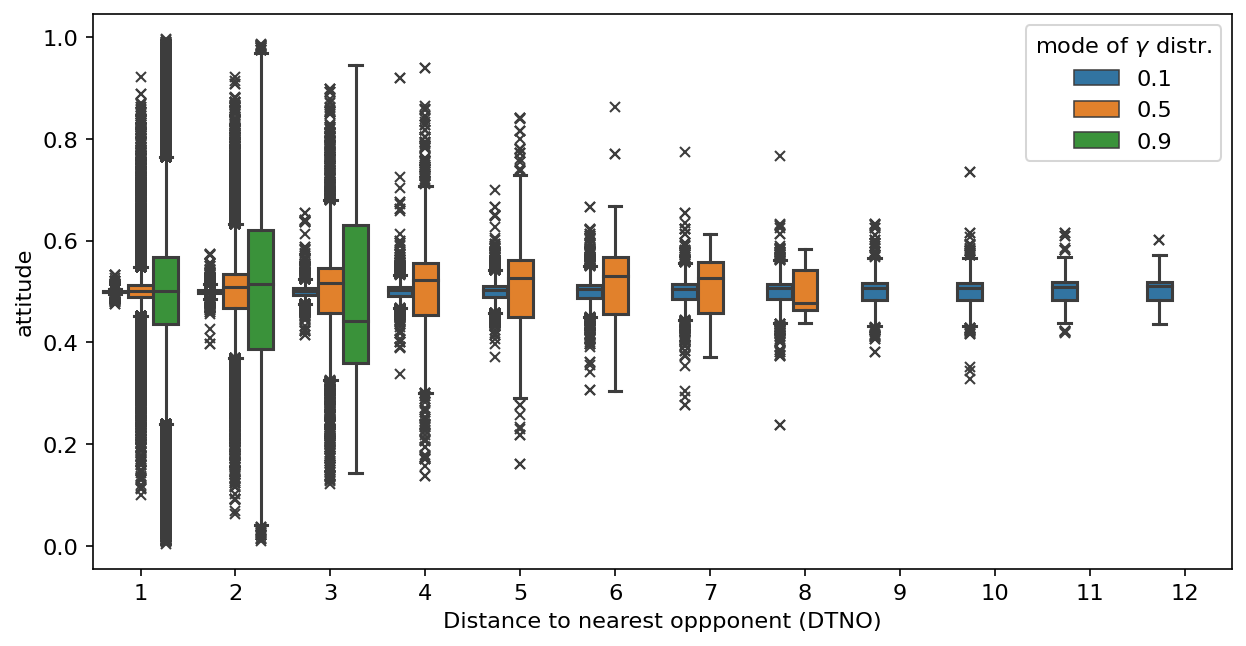

In [97]:
plt.figure(figsize=(10, 5))

beta_means = (0.1, 0.5, 0.9)

filtered_nearest_opponents_df = nearest_opponents_df[nearest_opponents_df["mode self-reliance"].isin([0.1, 0.5, 0.9])]
filtered_nearest_opponents_df.rename(columns={
    "self-reliance": "Self-reliance", 
    "distance": "Distance to nearest oppponent (DTNO)",
    "mode self-reliance": r"mode of $\gamma$ distr."
    }, inplace=True)
filtered_nearest_opponents_df = filtered_nearest_opponents_df[
    filtered_nearest_opponents_df["Distance to nearest oppponent (DTNO)"] <= 12]
sns.boxplot(data=filtered_nearest_opponents_df.sample(n=500_000), x="Distance to nearest oppponent (DTNO)", 
              y="attitude", hue=r"mode of $\gamma$ distr.", 
              showfliers=True, flierprops={"marker": "x"})
plt.show()

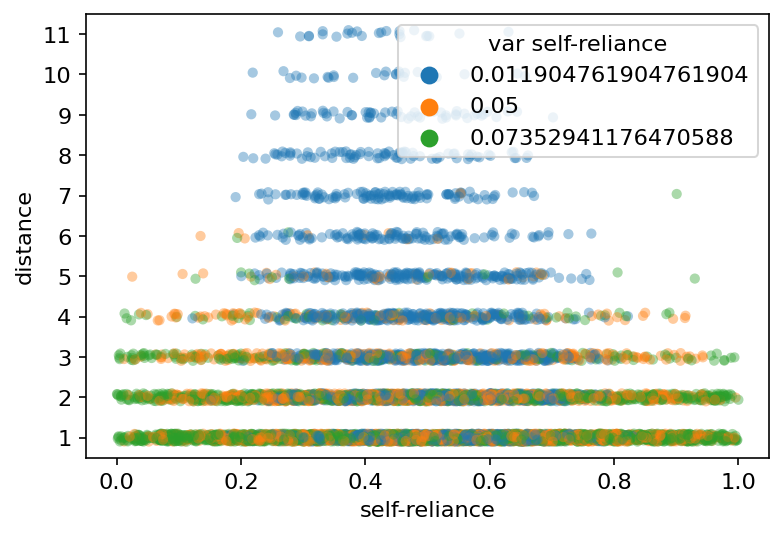

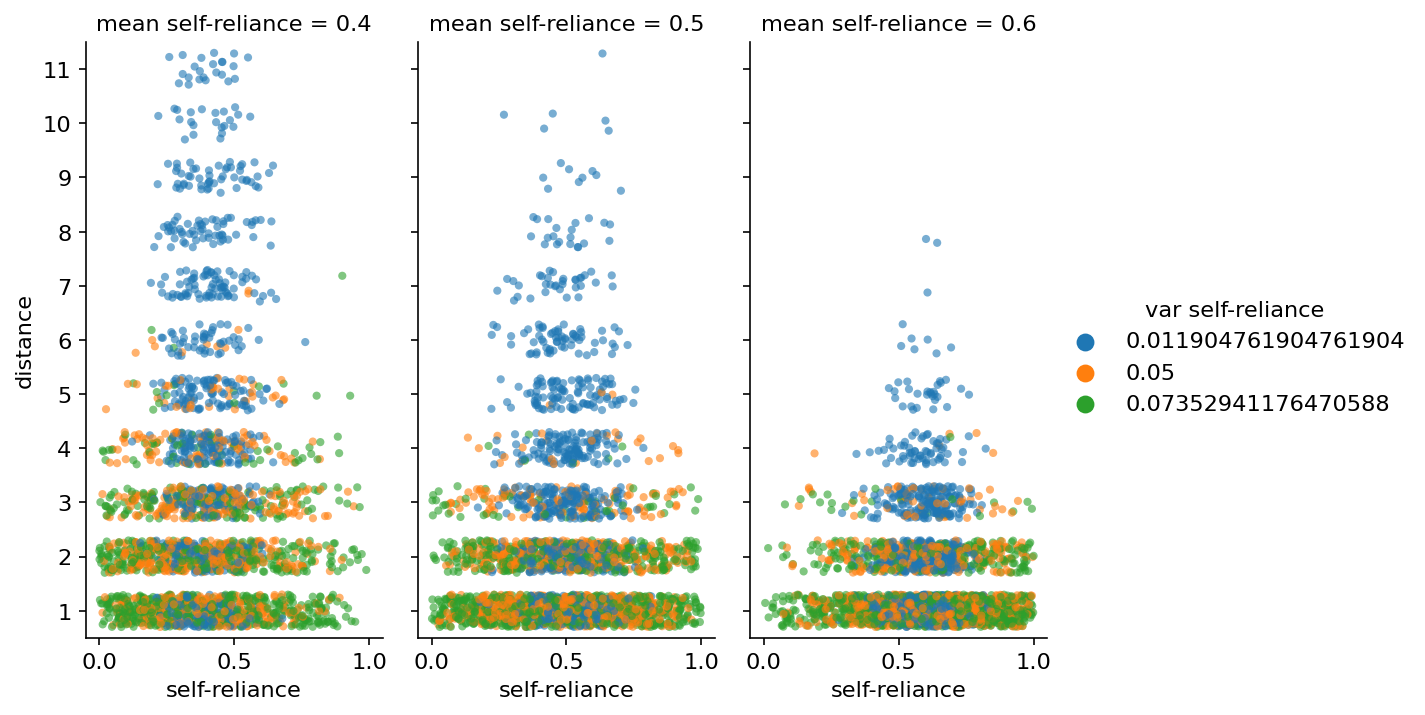

In [111]:
#sns.scatterplot(data=nearest_opponents_df, x="self-reliance", y="distance", hue="beta mean", s=4)
single_beta_samples = nearest_opponents_df[nearest_opponents_df["mean self-reliance"].isin([0.4, 0.5, 0.6])].sample(n=8_000)
single_beta_samples
sns.stripplot(data=single_beta_samples, x="self-reliance", y="distance", orient="h", hue="var self-reliance",
            alpha=0.4, order=np.arange(11, 0, -1))
sns.catplot(data=single_beta_samples, x="self-reliance", y="distance", 
            hue="var self-reliance", col="mean self-reliance", orient="h", aspect=.5, 
            alpha=0.6, order=np.arange(11, 0, -1), s=4, jitter=0.3)
plt.show()

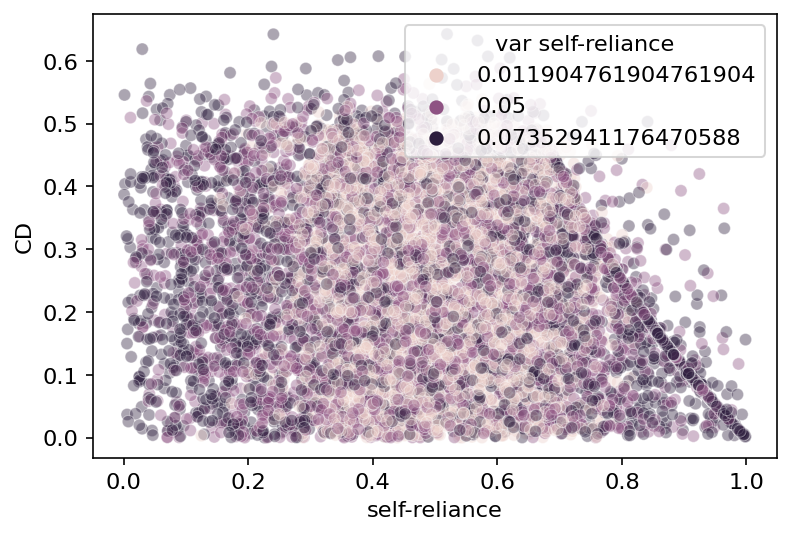

<Figure size 1470x735 with 0 Axes>

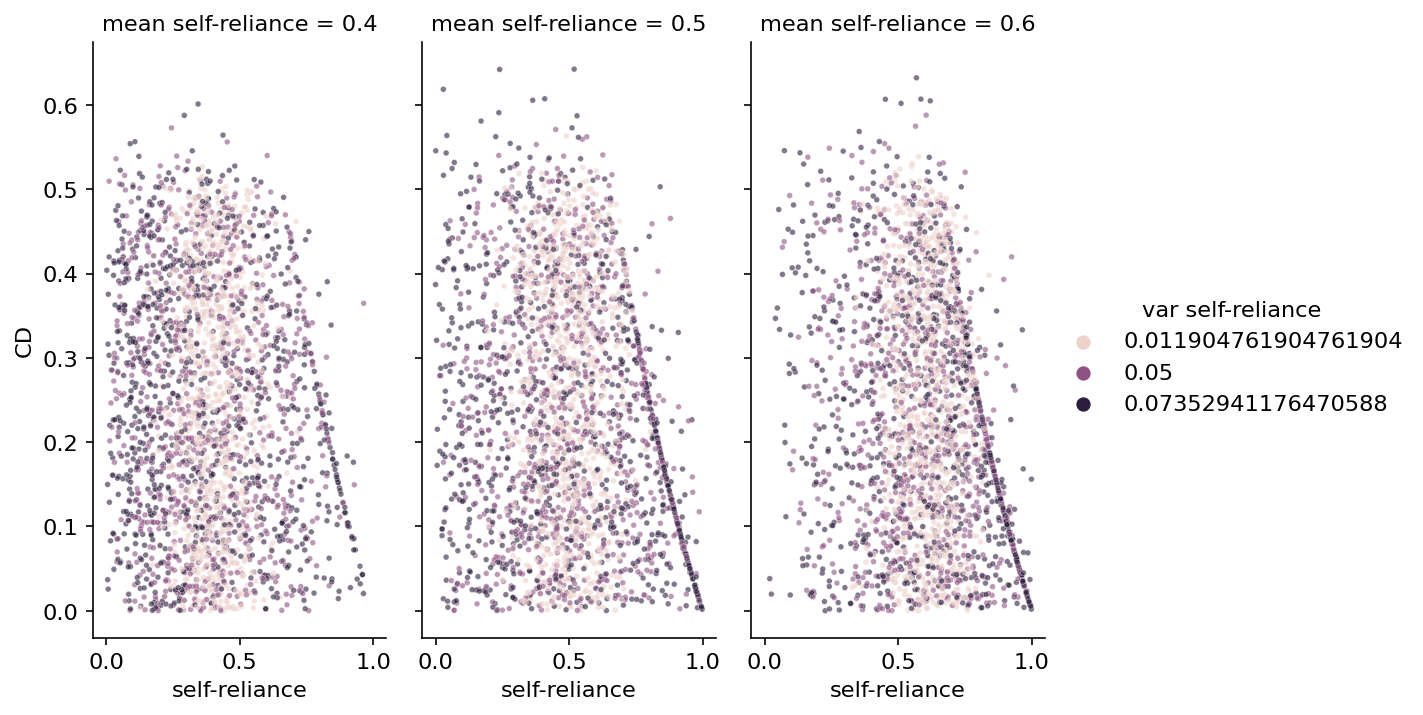

In [155]:
#sns.scatterplot(data=nearest_opponents_df, x="self-reliance", y="distance", hue="beta mean", s=4)
single_beta_samples = nearest_opponents_df[nearest_opponents_df["mean self-reliance"].isin([0.4, 0.5, 0.6])].sample(n=8_000)
single_beta_samples
sns.scatterplot(data=single_beta_samples, x="self-reliance", y="CD", hue="var self-reliance",
            alpha=0.4)

plt.figure(figsize=(10, 5))

sns.relplot(data=single_beta_samples, x="self-reliance", y="CD", kind="scatter",
            hue="var self-reliance", col="mean self-reliance", aspect=.5, 
            alpha=0.6, s=8)
plt.show()

In [173]:
np.arange(0.1, 1.0, 0.2).size

5

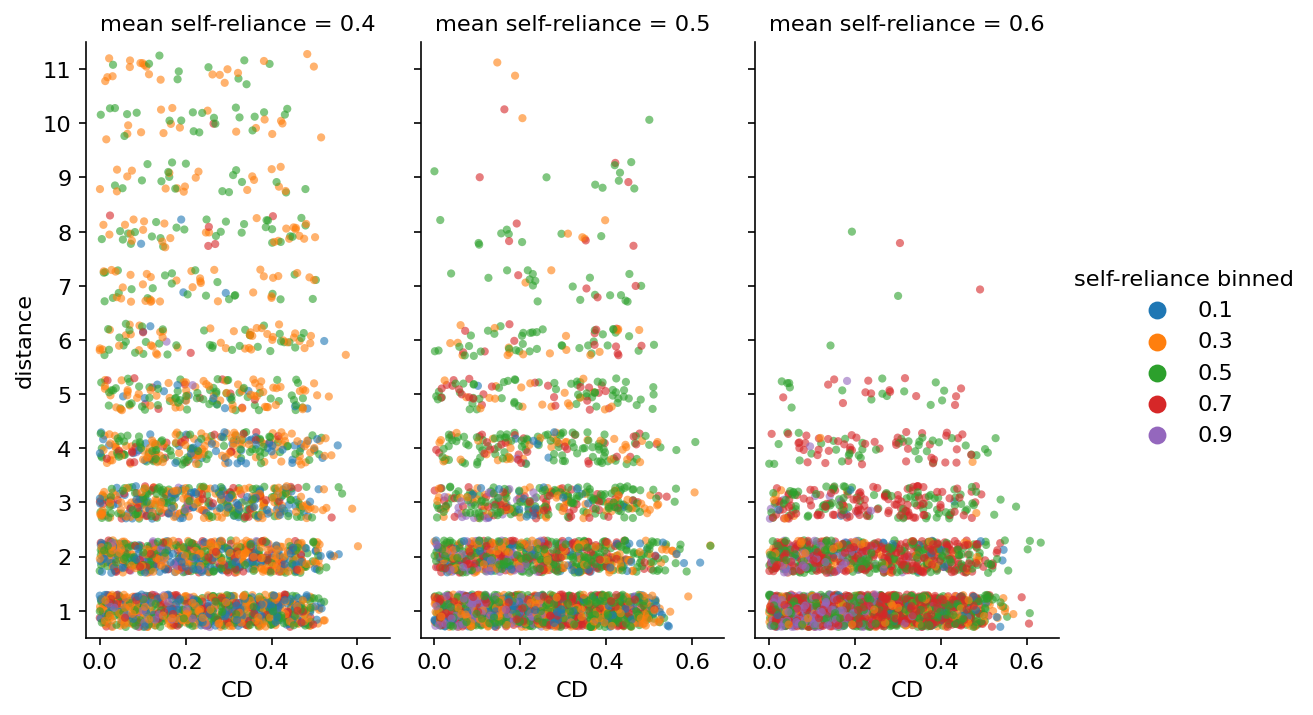

In [174]:
cd_distance_data = single_beta_samples.copy()

bins = np.linspace(0, 1., 6)
labels = np.around(np.arange(0.1, 1.0, 0.2), 2)
cd_distance_data["self-reliance binned"] = pd.cut(cd_distance_data['self-reliance'], bins=bins, labels=labels)

sns.catplot(data=cd_distance_data, x="CD", y="distance", hue="self-reliance binned",
             col="mean self-reliance", orient="h", aspect=.5, 
            alpha=0.6, order=np.arange(11, 0, -1), s=4, jitter=0.3)
plt.show()

<AxesSubplot:xlabel='total_bill'>

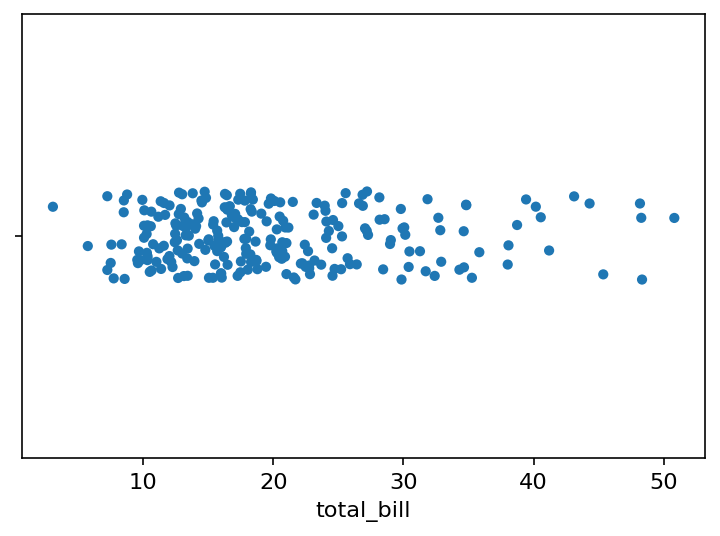

In [54]:
tips = sns.load_dataset("tips")
sns.stripplot(data=tips, x="total_bill")

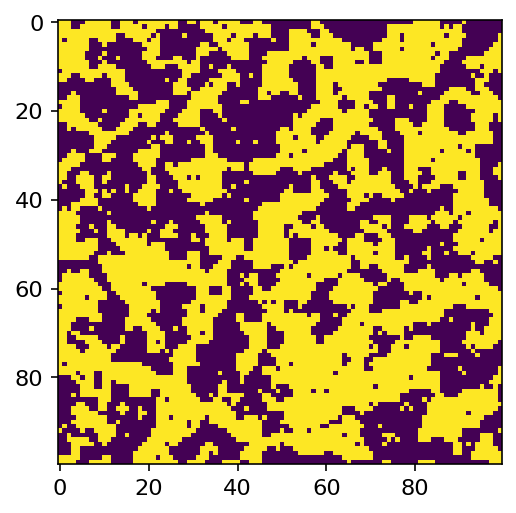

In [28]:
import matplotlib.pyplot as plt
plt.imshow(decisions)

In [29]:
distance_transform_cdt(~(arr == 1), metric='chessboard')

NameError: name 'arr' is not defined